In [ ]:
%%capture
from google.colab import drive
drive.mount('/content/gdrive')


!unzip /content/gdrive/MyDrive/data/cassava_dataset.zip -d /content/data

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g73ap5nUXSUvm24ZG5WrOf1U4arbxn9JD9mZXDWR7LklIKFBwa1dns


## Import Modules

In [ ]:
%%capture
!pip install timm
!pip install albumentations==0.4.6

In [ ]:
import os 
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# ====================================================
# Library
# ====================================================
import sys
sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')

import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform
import timm

from torch.cuda.amp import autocast, GradScaler

import warnings 
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data Loading

In [ ]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/sample_submission.csv')

def get_train_file_path(image_id):
    return f'data/train_images/{image_id}'

def get_test_file_path(image_id):
    return f'data/test_images/{image_id}'

train['file_path'] = train['image_id'].apply(get_train_file_path)
test['file_path'] = test['image_id'].apply(get_test_file_path)

In [ ]:
display(train.head())
display(test.head())

,image_id,label,file_path
0,1000015157.jpg,0,data/train_images/1000015157.jpg
1,1000201771.jpg,3,data/train_images/1000201771.jpg
2,100042118.jpg,1,data/train_images/100042118.jpg
3,1000723321.jpg,1,data/train_images/1000723321.jpg
4,1000812911.jpg,3,data/train_images/1000812911.jpg


,image_id,label,file_path
0,2216849948.jpg,4,data/test_images/2216849948.jpg


## Quick EDA

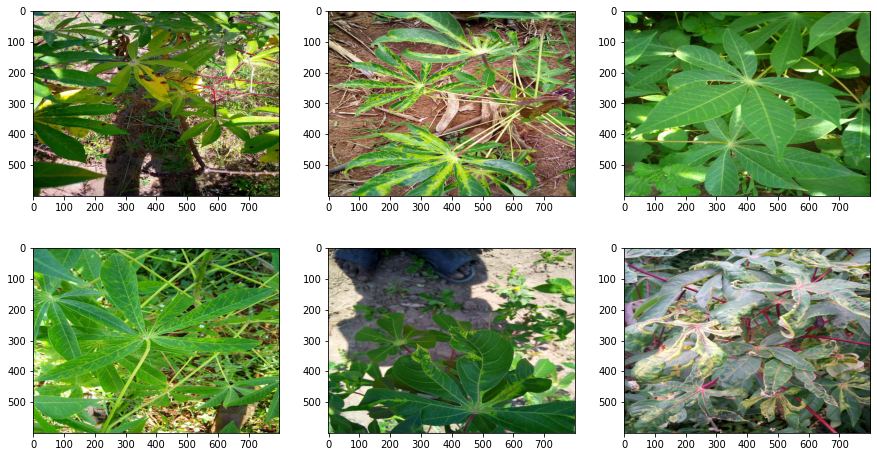

In [ ]:
plt.figure(figsize=(15, 8))
for i in range(6):
    image = np.array(Image.open((train.loc[i, 'file_path'])))  # float 16
#     image = cv2.resize(image, (224,224))
    plt.subplot(2,3,i+1)
    plt.imshow(image)
plt.show()

In [ ]:
import json

with open('/content/data/label_num_to_disease_map.json', 'r') as f:
    json_data = json.load(f)
# print(json_data)

train['label_name'] = train['label'].apply(lambda x: json_data[str(x)])

In [ ]:
train.head()

,image_id,label,file_path,label_name
0,1000015157.jpg,0,data/train_images/1000015157.jpg,Cassava Bacterial Blight (CBB)
1,1000201771.jpg,3,data/train_images/1000201771.jpg,Cassava Mosaic Disease (CMD)
2,100042118.jpg,1,data/train_images/100042118.jpg,Cassava Brown Streak Disease (CBSD)
3,1000723321.jpg,1,data/train_images/1000723321.jpg,Cassava Brown Streak Disease (CBSD)
4,1000812911.jpg,3,data/train_images/1000812911.jpg,Cassava Mosaic Disease (CMD)


## Directory settings

In [ ]:
import os

OUTPUT_DIR = './output'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

## CFG

In [ ]:
class CFG:
    apex=False
    debug=False
    print_freq=100
    num_workers=4
    model_name='resnet50' #'nfnet_l0'
    size=224
    scheduler='CosineAnnealingLR'
    epochs=6
    T_max=6  # CosineAnnealingLR
    lr=1e-4
    min_lr=1e-6
    batch_size=64
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    target_size=5
    target_col='label'
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    train=True
    
if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

## Utils

In [ ]:
def get_score(y_true, y_pred):
    y_true = torch.from_numpy(y_true)
    y_pred = torch.from_numpy(y_pred)
    correct = (y_true==y_pred).sum()

    return correct / len(y_true) * 100

def init_logger(log_file=os.path.join(OUTPUT_DIR,'train.log')):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()

def seed_torch(seed=CFG.seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch()

## cross validation split

In [ ]:
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_idx, val_idx) in enumerate(Fold.split(train, train[CFG.target_col])):
    train.loc[val_idx, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)

In [ ]:
train.groupby(['fold','label']).size()

fold  label
0     0         272
      1         547
      2         596
      3        3290
      4         645
1     0         272
      1         548
      2         596
      3        3289
      4         644
2     0         272
      1         547
      2         597
      3        3289
      4         644
3     0         271
      1         547
      2         597
      3        3290
      4         644
dtype: int64

## Dataset

In [ ]:
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.labels = df[CFG.target_col].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        file_path = self.file_names[idx]
        image = np.array(Image.open(file_path).convert('RGB'))
        if self.transform:
            image = self.transform(image=image)['image']

        label = self.labels[idx]
        
        return image, label

## Transforms

In [ ]:
def get_transforms(*, data):
    if data == 'train':
        return A.Compose([
            A.Resize(CFG.size, CFG.size),
            
            A.Normalize(mean=(0.485, 0.456, 0.406), 
                        std=(0.229, 0.224, 0.225),
                        max_pixel_value=255.),
            ToTensorV2(),
        ])
    elif data == 'valid':
        return A.Compose([
            A.Resize(CFG.size, CFG.size),
            
            A.Normalize(mean=(0.485, 0.456, 0.406), 
                        std=(0.229, 0.224, 0.225),
                        max_pixel_value=255.),
            ToTensorV2(),
        ])

## Model

In [34]:
class CustomModel(nn.Module):
    def __init__(self, cfg, pretrained=False):
        super().__init__()
        self.cfg = cfg

        self.model = timm.create_model('efficientnet_b4', pretrained=pretrained)
        self.n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(self.n_features, self.cfg.target_size)
        
    def forward(self, x):
        output = self.model(x)
        return output

## Helper functions

In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
def train_fn(train_loader, model, criterion, optimizer, epoch, sheculer, device):
    if CFG.apex:
        scaler = GradScaler()
    
    batch_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        batch_size = labels.size(0)
        if CFG.apex:  # FP16
            with autocast():
                y_preds = model(images)
                loss = criterion(y_preds, labels)
        else:
            y_preds = model(images)
            loss = criterion(y_preds, labels)
            
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps  # gpu개수만큼 loss 분할
        if CFG.apex:
            scaler.scale(loss).backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm(model.parameters(), CFG.max_grad_norm)  # gradient clipping
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            if CFG.apex:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()
            global_step +=1
        batch_time.update(time.time()-end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  #'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   #lr=scheduler.get_lr()[0],
                   ))
    return losses.avg

In [ ]:
def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(torch.argmax(y_preds, dim=1).to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

## Train loop

In [ ]:
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")
    train_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index
    
    train_folds = folds.loc[train_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_col].values
    
    train_dataset = TrainDataset(train_folds, transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data='valid'))
    
    train_loader = DataLoader(train_dataset,
                             batch_size=CFG.batch_size,
                             shuffle=True,
                             num_workers=CFG.num_workers,
                             pin_memory=True,
                             drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                             batch_size=CFG.batch_size,
                             shuffle=False,
                             num_workers=CFG.num_workers,
                             pin_memory=True,
                             drop_last=False)
    
    model = CustomModel(CFG, pretrained=True)
    model.to(device)
    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)  
    if CFG.scheduler == 'CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
    criterion = nn.CrossEntropyLoss()
    
    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        start_time = time.time()
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)
        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        
        if isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        score = get_score(valid_labels, preds)  # ROC AUC
        
        elapsed = time.time() - start_time
        
        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        
        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        os.path.join(OUTPUT_DIR, f'{CFG.model_name}_fold{fold}_best_score.pth'))
        
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        os.path.join(OUTPUT_DIR,f'{CFG.model_name}_fold{fold}_best_loss.pth'))
    
    valid_folds['preds'] = torch.load(os.path.join(OUTPUT_DIR,f'{CFG.model_name}_fold{fold}_best_loss.pth'), 
                                      map_location=torch.device('cpu'))['preds']

    return valid_folds

In [ ]:
def main():
    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
        
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(os.path.join(OUTPUT_DIR, 'oof_df.csv'), index=False)
        

In [35]:
if __name__ == '__main__':
    import pdb
    main()

========== fold: 0 training ==========
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b4_ra2_320-7eb33cd5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_ra2_320-7eb33cd5.pth


Epoch: [1][0/250] Elapsed 0m 2s (remain 10m 17s) Loss: 1.6014(1.6014) Grad: 1.2799  
Epoch: [1][100/250] Elapsed 1m 2s (remain 1m 32s) Loss: 1.0043(1.1223) Grad: 1.1057  
Epoch: [1][200/250] Elapsed 2m 2s (remain 0m 29s) Loss: 0.7691(0.9833) Grad: 0.9723  
Epoch: [1][249/250] Elapsed 2m 31s (remain 0m 0s) Loss: 0.7886(0.9373) Grad: 0.9645  
EVAL: [0/84] Data 1.393 (1.393) Elapsed 0m 1s (remain 2m 7s) Loss: 0.5859(0.5859) 


Epoch 1 - avg_train_loss: 0.9373  avg_val_loss: 0.7312  time: 176s
Epoch 1 - Score: 73.2710
Epoch 1 - Save Best Score: 73.2710 Model


EVAL: [83/84] Data 0.000 (0.138) Elapsed 0m 23s (remain 0m 0s) Loss: 0.8623(0.7312) 


Epoch 1 - Save Best Loss: 0.7312 Model


Epoch: [2][0/250] Elapsed 0m 2s (remain 8m 24s) Loss: 0.7985(0.7985) Grad: 1.1062  
Epoch: [2][100/250] Elapsed 1m 2s (remain 1m 31s) Loss: 0.5512(0.6157) Grad: 0.9834  
Epoch: [2][200/250] Elapsed 2m 2s (remain 0m 29s) Loss: 0.4332(0.5997) Grad: 1.1730  
Epoch: [2][249/250] Elapsed 2m 31s (remain 0m 0s) Loss: 0.8159(0.5911) Grad: 2.0226  
EVAL: [0/84] Data 1.421 (1.421) Elapsed 0m 1s (remain 2m 9s) Loss: 0.4947(0.4947) 


Epoch 2 - avg_train_loss: 0.5911  avg_val_loss: 0.6182  time: 175s
Epoch 2 - Score: 77.9065
Epoch 2 - Save Best Score: 77.9065 Model


EVAL: [83/84] Data 0.000 (0.137) Elapsed 0m 23s (remain 0m 0s) Loss: 0.7923(0.6182) 


Epoch 2 - Save Best Loss: 0.6182 Model


Epoch: [3][0/250] Elapsed 0m 2s (remain 8m 41s) Loss: 0.3704(0.3704) Grad: 0.8010  
Epoch: [3][100/250] Elapsed 1m 2s (remain 1m 31s) Loss: 0.3026(0.4036) Grad: 0.9339  
Epoch: [3][200/250] Elapsed 2m 2s (remain 0m 29s) Loss: 0.4155(0.3897) Grad: 0.9675  
Epoch: [3][249/250] Elapsed 2m 31s (remain 0m 0s) Loss: 0.3498(0.3913) Grad: 1.0018  
EVAL: [0/84] Data 1.346 (1.346) Elapsed 0m 1s (remain 2m 3s) Loss: 0.4964(0.4964) 


Epoch 3 - avg_train_loss: 0.3913  avg_val_loss: 0.6298  time: 176s
Epoch 3 - Score: 78.8224
Epoch 3 - Save Best Score: 78.8224 Model


EVAL: [83/84] Data 0.000 (0.139) Elapsed 0m 23s (remain 0m 0s) Loss: 0.8103(0.6298) 
Epoch: [4][0/250] Elapsed 0m 2s (remain 8m 48s) Loss: 0.3836(0.3836) Grad: 0.9242  
Epoch: [4][100/250] Elapsed 1m 2s (remain 1m 32s) Loss: 0.2202(0.2700) Grad: 1.0594  
Epoch: [4][200/250] Elapsed 2m 2s (remain 0m 29s) Loss: 0.2932(0.2663) Grad: 1.4302  
Epoch: [4][249/250] Elapsed 2m 32s (remain 0m 0s) Loss: 0.2860(0.2664) Grad: 1.3105  
EVAL: [0/84] Data 1.390 (1.390) Elapsed 0m 1s (remain 2m 7s) Loss: 0.5297(0.5297) 


Epoch 4 - avg_train_loss: 0.2664  avg_val_loss: 0.6711  time: 176s
Epoch 4 - Score: 79.1215
Epoch 4 - Save Best Score: 79.1215 Model


EVAL: [83/84] Data 0.000 (0.133) Elapsed 0m 23s (remain 0m 0s) Loss: 0.9035(0.6711) 
Epoch: [5][0/250] Elapsed 0m 1s (remain 8m 8s) Loss: 0.2161(0.2161) Grad: 0.9791  
Epoch: [5][100/250] Elapsed 1m 2s (remain 1m 31s) Loss: 0.1615(0.2010) Grad: 0.7246  
Epoch: [5][200/250] Elapsed 2m 2s (remain 0m 29s) Loss: 0.1497(0.2012) Grad: 0.7737  
Epoch: [5][249/250] Elapsed 2m 31s (remain 0m 0s) Loss: 0.1869(0.1992) Grad: 0.9958  
EVAL: [0/84] Data 1.337 (1.337) Elapsed 0m 1s (remain 2m 2s) Loss: 0.5739(0.5739) 


Epoch 5 - avg_train_loss: 0.1992  avg_val_loss: 0.7196  time: 176s
Epoch 5 - Score: 78.8972


EVAL: [83/84] Data 0.000 (0.144) Elapsed 0m 24s (remain 0m 0s) Loss: 0.9519(0.7196) 
Epoch: [6][0/250] Elapsed 0m 2s (remain 8m 25s) Loss: 0.1209(0.1209) Grad: 1.0691  
Epoch: [6][100/250] Elapsed 1m 2s (remain 1m 31s) Loss: 0.1788(0.1683) Grad: 0.7832  
Epoch: [6][200/250] Elapsed 2m 1s (remain 0m 29s) Loss: 0.2797(0.1719) Grad: 1.6447  
Epoch: [6][249/250] Elapsed 2m 31s (remain 0m 0s) Loss: 0.1403(0.1697) Grad: 1.0387  
EVAL: [0/84] Data 1.402 (1.402) Elapsed 0m 1s (remain 2m 8s) Loss: 0.5876(0.5876) 


Epoch 6 - avg_train_loss: 0.1697  avg_val_loss: 0.7362  time: 175s
Epoch 6 - Score: 78.9533


EVAL: [83/84] Data 0.000 (0.134) Elapsed 0m 23s (remain 0m 0s) Loss: 0.9500(0.7362) 


========== fold: 0 result ==========
Score: 77.9065
========== fold: 1 training ==========


Epoch: [1][0/250] Elapsed 0m 2s (remain 8m 26s) Loss: 1.6049(1.6049) Grad: 1.2882  
Epoch: [1][100/250] Elapsed 1m 2s (remain 1m 31s) Loss: 0.8319(1.1200) Grad: 0.9012  
Epoch: [1][200/250] Elapsed 2m 2s (remain 0m 29s) Loss: 0.6129(0.9844) Grad: 1.0861  
Epoch: [1][249/250] Elapsed 2m 32s (remain 0m 0s) Loss: 0.6293(0.9411) Grad: 1.1755  
EVAL: [0/84] Data 1.440 (1.440) Elapsed 0m 1s (remain 2m 11s) Loss: 0.7882(0.7882) 


Epoch 1 - avg_train_loss: 0.9411  avg_val_loss: 0.7287  time: 176s
Epoch 1 - Score: 73.2286
Epoch 1 - Save Best Score: 73.2286 Model


EVAL: [83/84] Data 0.000 (0.134) Elapsed 0m 23s (remain 0m 0s) Loss: 0.7396(0.7287) 


Epoch 1 - Save Best Loss: 0.7287 Model


Epoch: [2][0/250] Elapsed 0m 2s (remain 8m 32s) Loss: 0.5929(0.5929) Grad: 0.7257  
Epoch: [2][100/250] Elapsed 1m 2s (remain 1m 31s) Loss: 0.6129(0.6329) Grad: 1.1588  
Epoch: [2][200/250] Elapsed 2m 2s (remain 0m 29s) Loss: 0.6404(0.6035) Grad: 1.3252  
Epoch: [2][249/250] Elapsed 2m 32s (remain 0m 0s) Loss: 0.4454(0.5919) Grad: 1.0273  
EVAL: [0/84] Data 1.446 (1.446) Elapsed 0m 1s (remain 2m 11s) Loss: 0.6549(0.6549) 


Epoch 2 - avg_train_loss: 0.5919  avg_val_loss: 0.6063  time: 176s
Epoch 2 - Score: 78.4259
Epoch 2 - Save Best Score: 78.4259 Model


EVAL: [83/84] Data 0.000 (0.137) Elapsed 0m 23s (remain 0m 0s) Loss: 0.5583(0.6063) 


Epoch 2 - Save Best Loss: 0.6063 Model


Epoch: [3][0/250] Elapsed 0m 2s (remain 8m 59s) Loss: 0.4986(0.4986) Grad: 1.0356  
Epoch: [3][100/250] Elapsed 1m 2s (remain 1m 32s) Loss: 0.2430(0.4107) Grad: 0.7795  
Epoch: [3][200/250] Elapsed 2m 2s (remain 0m 29s) Loss: 0.4122(0.3952) Grad: 1.2106  
Epoch: [3][249/250] Elapsed 2m 32s (remain 0m 0s) Loss: 0.3173(0.3905) Grad: 1.1103  
EVAL: [0/84] Data 1.367 (1.367) Elapsed 0m 1s (remain 2m 5s) Loss: 0.6472(0.6472) 


Epoch 3 - avg_train_loss: 0.3905  avg_val_loss: 0.6131  time: 176s
Epoch 3 - Score: 79.4541
Epoch 3 - Save Best Score: 79.4541 Model


EVAL: [83/84] Data 0.000 (0.137) Elapsed 0m 23s (remain 0m 0s) Loss: 0.4999(0.6131) 
Epoch: [4][0/250] Elapsed 0m 2s (remain 8m 29s) Loss: 0.3999(0.3999) Grad: 1.1385  
Epoch: [4][100/250] Elapsed 1m 2s (remain 1m 31s) Loss: 0.2275(0.2716) Grad: 0.7438  
Epoch: [4][200/250] Elapsed 2m 2s (remain 0m 29s) Loss: 0.3678(0.2692) Grad: 1.4913  
Epoch: [4][249/250] Elapsed 2m 31s (remain 0m 0s) Loss: 0.3006(0.2639) Grad: 1.2655  
EVAL: [0/84] Data 1.458 (1.458) Elapsed 0m 1s (remain 2m 12s) Loss: 0.6848(0.6848) 


Epoch 4 - avg_train_loss: 0.2639  avg_val_loss: 0.6828  time: 176s
Epoch 4 - Score: 79.4728
Epoch 4 - Save Best Score: 79.4728 Model


EVAL: [83/84] Data 0.000 (0.140) Elapsed 0m 23s (remain 0m 0s) Loss: 0.5844(0.6828) 
Epoch: [5][0/250] Elapsed 0m 2s (remain 8m 36s) Loss: 0.1595(0.1595) Grad: 0.6499  
Epoch: [5][100/250] Elapsed 1m 2s (remain 1m 31s) Loss: 0.3693(0.1921) Grad: 1.1935  
Epoch: [5][200/250] Elapsed 2m 1s (remain 0m 29s) Loss: 0.1949(0.1966) Grad: 0.8870  
Epoch: [5][249/250] Elapsed 2m 31s (remain 0m 0s) Loss: 0.3114(0.1972) Grad: 1.6664  
EVAL: [0/84] Data 1.511 (1.511) Elapsed 0m 1s (remain 2m 17s) Loss: 0.7222(0.7222) 


Epoch 5 - avg_train_loss: 0.1972  avg_val_loss: 0.7196  time: 176s
Epoch 5 - Score: 79.1737


EVAL: [83/84] Data 0.000 (0.144) Elapsed 0m 24s (remain 0m 0s) Loss: 0.6299(0.7196) 
Epoch: [6][0/250] Elapsed 0m 2s (remain 8m 30s) Loss: 0.1129(0.1129) Grad: 0.7964  
Epoch: [6][100/250] Elapsed 1m 1s (remain 1m 31s) Loss: 0.1286(0.1659) Grad: 0.6695  
Epoch: [6][200/250] Elapsed 2m 1s (remain 0m 29s) Loss: 0.1253(0.1626) Grad: 0.7510  
Epoch: [6][249/250] Elapsed 2m 31s (remain 0m 0s) Loss: 0.0831(0.1627) Grad: 0.6129  
EVAL: [0/84] Data 1.435 (1.435) Elapsed 0m 1s (remain 2m 11s) Loss: 0.7580(0.7580) 


Epoch 6 - avg_train_loss: 0.1627  avg_val_loss: 0.7559  time: 175s
Epoch 6 - Score: 79.0615


EVAL: [83/84] Data 0.000 (0.143) Elapsed 0m 23s (remain 0m 0s) Loss: 0.7020(0.7559) 


========== fold: 1 result ==========
Score: 78.4259
========== fold: 2 training ==========


Epoch: [1][0/250] Elapsed 0m 2s (remain 8m 37s) Loss: 1.6141(1.6141) Grad: 1.3305  
Epoch: [1][100/250] Elapsed 1m 1s (remain 1m 31s) Loss: 0.7882(1.1406) Grad: 1.0224  
Epoch: [1][200/250] Elapsed 2m 1s (remain 0m 29s) Loss: 0.9412(0.9848) Grad: 1.4690  
Epoch: [1][249/250] Elapsed 2m 31s (remain 0m 0s) Loss: 0.6738(0.9410) Grad: 0.8794  
EVAL: [0/84] Data 1.432 (1.432) Elapsed 0m 1s (remain 2m 12s) Loss: 0.8226(0.8226) 


Epoch 1 - avg_train_loss: 0.9410  avg_val_loss: 0.7459  time: 175s
Epoch 1 - Score: 72.4061
Epoch 1 - Save Best Score: 72.4061 Model


EVAL: [83/84] Data 0.000 (0.143) Elapsed 0m 24s (remain 0m 0s) Loss: 0.7741(0.7459) 


Epoch 1 - Save Best Loss: 0.7459 Model


Epoch: [2][0/250] Elapsed 0m 1s (remain 8m 16s) Loss: 0.5815(0.5815) Grad: 0.9294  
Epoch: [2][100/250] Elapsed 1m 2s (remain 1m 31s) Loss: 0.7761(0.6301) Grad: 1.3511  
Epoch: [2][200/250] Elapsed 2m 2s (remain 0m 29s) Loss: 0.6768(0.6099) Grad: 1.3624  
Epoch: [2][249/250] Elapsed 2m 31s (remain 0m 0s) Loss: 0.7053(0.5946) Grad: 1.6366  
EVAL: [0/84] Data 1.441 (1.441) Elapsed 0m 1s (remain 2m 11s) Loss: 0.6531(0.6531) 


Epoch 2 - avg_train_loss: 0.5946  avg_val_loss: 0.6366  time: 176s
Epoch 2 - Score: 76.6685
Epoch 2 - Save Best Score: 76.6685 Model


EVAL: [83/84] Data 0.000 (0.136) Elapsed 0m 23s (remain 0m 0s) Loss: 0.6305(0.6366) 


Epoch 2 - Save Best Loss: 0.6366 Model


Epoch: [3][0/250] Elapsed 0m 2s (remain 8m 49s) Loss: 0.4951(0.4951) Grad: 1.2015  
Epoch: [3][100/250] Elapsed 1m 2s (remain 1m 31s) Loss: 0.3882(0.4057) Grad: 1.1367  
Epoch: [3][200/250] Elapsed 2m 2s (remain 0m 29s) Loss: 0.2488(0.4003) Grad: 0.8520  
Epoch: [3][249/250] Elapsed 2m 32s (remain 0m 0s) Loss: 0.5321(0.3983) Grad: 1.4210  
EVAL: [0/84] Data 1.445 (1.445) Elapsed 0m 1s (remain 2m 12s) Loss: 0.7161(0.7161) 


Epoch 3 - avg_train_loss: 0.3983  avg_val_loss: 0.6336  time: 175s
Epoch 3 - Score: 77.9585
Epoch 3 - Save Best Score: 77.9585 Model


EVAL: [83/84] Data 0.000 (0.132) Elapsed 0m 23s (remain 0m 0s) Loss: 0.6302(0.6336) 


Epoch 3 - Save Best Loss: 0.6336 Model


Epoch: [4][0/250] Elapsed 0m 2s (remain 8m 25s) Loss: 0.2473(0.2473) Grad: 1.1843  
Epoch: [4][100/250] Elapsed 1m 2s (remain 1m 31s) Loss: 0.2137(0.2722) Grad: 0.9875  
Epoch: [4][200/250] Elapsed 2m 2s (remain 0m 29s) Loss: 0.2654(0.2754) Grad: 1.1975  
Epoch: [4][249/250] Elapsed 2m 31s (remain 0m 0s) Loss: 0.2064(0.2742) Grad: 1.0116  
EVAL: [0/84] Data 1.516 (1.516) Elapsed 0m 1s (remain 2m 17s) Loss: 0.7432(0.7432) 


Epoch 4 - avg_train_loss: 0.2742  avg_val_loss: 0.7033  time: 177s
Epoch 4 - Score: 77.9024


EVAL: [83/84] Data 0.000 (0.150) Elapsed 0m 24s (remain 0m 0s) Loss: 0.6433(0.7033) 
Epoch: [5][0/250] Elapsed 0m 2s (remain 8m 47s) Loss: 0.1995(0.1995) Grad: 1.1657  
Epoch: [5][100/250] Elapsed 1m 2s (remain 1m 31s) Loss: 0.1429(0.2205) Grad: 0.7330  
Epoch: [5][200/250] Elapsed 2m 2s (remain 0m 29s) Loss: 0.1235(0.2100) Grad: 1.1418  
Epoch: [5][249/250] Elapsed 2m 31s (remain 0m 0s) Loss: 0.1739(0.2051) Grad: 0.8222  
EVAL: [0/84] Data 1.338 (1.338) Elapsed 0m 1s (remain 2m 2s) Loss: 0.8252(0.8252) 


Epoch 5 - avg_train_loss: 0.2051  avg_val_loss: 0.7322  time: 176s
Epoch 5 - Score: 78.3137
Epoch 5 - Save Best Score: 78.3137 Model


EVAL: [83/84] Data 0.000 (0.136) Elapsed 0m 23s (remain 0m 0s) Loss: 0.7035(0.7322) 
Epoch: [6][0/250] Elapsed 0m 2s (remain 8m 37s) Loss: 0.0986(0.0986) Grad: 0.7144  
Epoch: [6][100/250] Elapsed 1m 2s (remain 1m 32s) Loss: 0.1164(0.1675) Grad: 0.9125  
Epoch: [6][200/250] Elapsed 2m 2s (remain 0m 29s) Loss: 0.1090(0.1711) Grad: 0.8703  
Epoch: [6][249/250] Elapsed 2m 32s (remain 0m 0s) Loss: 0.1725(0.1718) Grad: 1.1479  
EVAL: [0/84] Data 1.395 (1.395) Elapsed 0m 1s (remain 2m 8s) Loss: 0.9638(0.9638) 


Epoch 6 - avg_train_loss: 0.1718  avg_val_loss: 0.7768  time: 176s
Epoch 6 - Score: 78.0707


EVAL: [83/84] Data 0.000 (0.136) Elapsed 0m 23s (remain 0m 0s) Loss: 0.7554(0.7768) 


========== fold: 2 result ==========
Score: 77.9585
========== fold: 3 training ==========


Epoch: [1][0/250] Elapsed 0m 2s (remain 8m 47s) Loss: 1.6242(1.6242) Grad: 1.1785  
Epoch: [1][100/250] Elapsed 1m 2s (remain 1m 31s) Loss: 0.9860(1.1422) Grad: 0.8993  
Epoch: [1][200/250] Elapsed 2m 2s (remain 0m 29s) Loss: 0.7883(0.9995) Grad: 1.0684  
Epoch: [1][249/250] Elapsed 2m 31s (remain 0m 0s) Loss: 0.6432(0.9501) Grad: 0.9061  
EVAL: [0/84] Data 1.389 (1.389) Elapsed 0m 1s (remain 2m 7s) Loss: 0.9014(0.9014) 


Epoch 1 - avg_train_loss: 0.9501  avg_val_loss: 0.7211  time: 176s
Epoch 1 - Score: 73.7708
Epoch 1 - Save Best Score: 73.7708 Model


EVAL: [83/84] Data 0.000 (0.138) Elapsed 0m 23s (remain 0m 0s) Loss: 0.7446(0.7211) 


Epoch 1 - Save Best Loss: 0.7211 Model


Epoch: [2][0/250] Elapsed 0m 1s (remain 8m 11s) Loss: 0.7550(0.7550) Grad: 0.9358  
Epoch: [2][100/250] Elapsed 1m 2s (remain 1m 31s) Loss: 0.5078(0.6049) Grad: 0.8663  
Epoch: [2][200/250] Elapsed 2m 2s (remain 0m 29s) Loss: 0.4956(0.5918) Grad: 1.1487  
Epoch: [2][249/250] Elapsed 2m 31s (remain 0m 0s) Loss: 0.6283(0.5880) Grad: 1.8370  
EVAL: [0/84] Data 1.388 (1.388) Elapsed 0m 1s (remain 2m 7s) Loss: 0.8603(0.8603) 


Epoch 2 - avg_train_loss: 0.5880  avg_val_loss: 0.6030  time: 175s
Epoch 2 - Score: 78.6315
Epoch 2 - Save Best Score: 78.6315 Model


EVAL: [83/84] Data 0.000 (0.136) Elapsed 0m 23s (remain 0m 0s) Loss: 0.5998(0.6030) 


Epoch 2 - Save Best Loss: 0.6030 Model


Epoch: [3][0/250] Elapsed 0m 2s (remain 8m 34s) Loss: 0.3680(0.3680) Grad: 0.7723  
Epoch: [3][100/250] Elapsed 1m 2s (remain 1m 32s) Loss: 0.3148(0.3997) Grad: 1.0600  
Epoch: [3][200/250] Elapsed 2m 2s (remain 0m 29s) Loss: 0.4727(0.3882) Grad: 1.3070  
Epoch: [3][249/250] Elapsed 2m 32s (remain 0m 0s) Loss: 0.2957(0.3870) Grad: 1.1788  
EVAL: [0/84] Data 1.400 (1.400) Elapsed 0m 1s (remain 2m 8s) Loss: 1.0187(1.0187) 


Epoch 3 - avg_train_loss: 0.3870  avg_val_loss: 0.6193  time: 176s
Epoch 3 - Score: 79.4915
Epoch 3 - Save Best Score: 79.4915 Model


EVAL: [83/84] Data 0.000 (0.138) Elapsed 0m 23s (remain 0m 0s) Loss: 0.6231(0.6193) 
Epoch: [4][0/250] Elapsed 0m 1s (remain 8m 10s) Loss: 0.3305(0.3305) Grad: 0.9781  
Epoch: [4][100/250] Elapsed 1m 2s (remain 1m 31s) Loss: 0.1846(0.2694) Grad: 1.0552  
Epoch: [4][200/250] Elapsed 2m 2s (remain 0m 29s) Loss: 0.2309(0.2656) Grad: 1.3332  
Epoch: [4][249/250] Elapsed 2m 31s (remain 0m 0s) Loss: 0.2523(0.2629) Grad: 1.4450  
EVAL: [0/84] Data 1.407 (1.407) Elapsed 0m 1s (remain 2m 8s) Loss: 1.1484(1.1484) 


Epoch 4 - avg_train_loss: 0.2629  avg_val_loss: 0.6732  time: 175s
Epoch 4 - Score: 79.0615


EVAL: [83/84] Data 0.000 (0.136) Elapsed 0m 23s (remain 0m 0s) Loss: 0.6939(0.6732) 
Epoch: [5][0/250] Elapsed 0m 2s (remain 8m 28s) Loss: 0.2807(0.2807) Grad: 1.0717  
Epoch: [5][100/250] Elapsed 1m 2s (remain 1m 32s) Loss: 0.1213(0.1964) Grad: 0.7351  
Epoch: [5][200/250] Elapsed 2m 2s (remain 0m 29s) Loss: 0.1714(0.1970) Grad: 1.0023  
Epoch: [5][249/250] Elapsed 2m 32s (remain 0m 0s) Loss: 0.1212(0.1967) Grad: 0.6985  
EVAL: [0/84] Data 1.381 (1.381) Elapsed 0m 1s (remain 2m 6s) Loss: 1.2348(1.2348) 


Epoch 5 - avg_train_loss: 0.1967  avg_val_loss: 0.7133  time: 176s
Epoch 5 - Score: 78.9493


EVAL: [83/84] Data 0.000 (0.139) Elapsed 0m 23s (remain 0m 0s) Loss: 0.6859(0.7133) 
Epoch: [6][0/250] Elapsed 0m 2s (remain 8m 51s) Loss: 0.1590(0.1590) Grad: 1.0759  
Epoch: [6][100/250] Elapsed 1m 2s (remain 1m 31s) Loss: 0.1386(0.1611) Grad: 0.8188  
Epoch: [6][200/250] Elapsed 2m 2s (remain 0m 29s) Loss: 0.1519(0.1619) Grad: 0.9620  
Epoch: [6][249/250] Elapsed 2m 31s (remain 0m 0s) Loss: 0.2137(0.1629) Grad: 1.0986  
EVAL: [0/84] Data 1.409 (1.409) Elapsed 0m 1s (remain 2m 8s) Loss: 1.2392(1.2392) 


Epoch 6 - avg_train_loss: 0.1629  avg_val_loss: 0.7270  time: 176s
Epoch 6 - Score: 78.5754


EVAL: [83/84] Data 0.000 (0.141) Elapsed 0m 23s (remain 0m 0s) Loss: 0.7576(0.7270) 


========== fold: 3 result ==========
Score: 78.6315
========== CV ==========
Score: 78.2306


In [ ]:
# resnet 50(base line) : 83.1939
# nfnet l0 : 85.5260
# resnext50_32x4d : 83.2593
# efficientnet_b4 : 78.2306

## Inference

In [ ]:
model = CustomModel(CFG, pretrained=True)
check_point = torch.load('/content/output/resnet50_fold1_best_loss.pth')['model']
model.load_state_dict(check_point)
model.to(device)

test_transform = A.Compose([
            A.Resize(CFG.size, CFG.size),
            A.Normalize(mean=(0.485, 0.456, 0.406), 
                        std=(0.229, 0.224, 0.225),
                        max_pixel_value=255.),
            ToTensorV2(),
        ])

test_dataset = TrainDataset(test, transform=test_transform)

output = model(test_dataset[0][0].unsqueeze(0).to(device))
predicted = output.argmax(1).item()

test['label'] = predicted
test[['image_id','label']].to_csv(f'{OUTPUT_DIR}/submission.csv', index=False)
test.head()

,image_id,label,file_path
0,2216849948.jpg,3,data/test_images/2216849948.jpg


In [33]:
model = timm.create_model('efficientnet_b4')
model
# from torchsummary import summary
# summary(model, input_size=(3, 512, 512), device='cpu')

EfficientNet(
  (conv_stem): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
      (1): DepthwiseS